In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

# Fidelity Benchmark

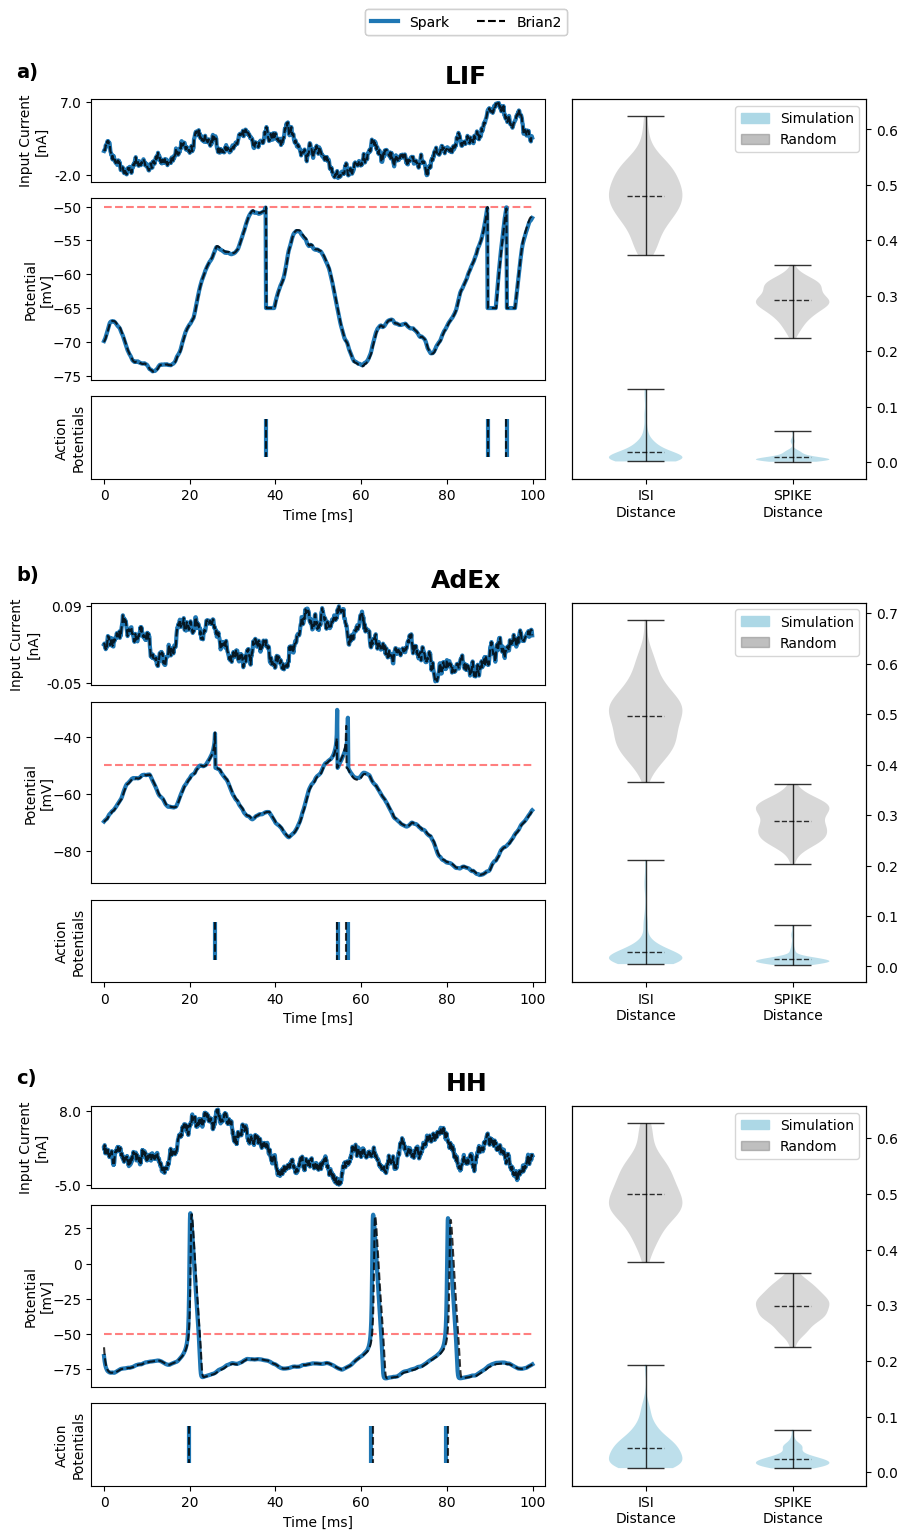

In [119]:
def populate_subfigure(
		subfig, title, subfig_index, input_current, firing_threshold,
		b2_times, b2_potentials, b2_spikes, 
		spark_times, spark_potentials, spark_spikes,
		metrics, decimals=0,
	) -> None:

	import matplotlib
	font = {'family' : 'sans-serif',
			#'weight' : 'bold',
			'size'   : 10}
	matplotlib.rc('font', **font)
	#matplotlib.rc('axes', labelweight='bold', titleweight='bold')
	matplotlib.rc('figure', titlesize=18, titleweight='bold')
	
	subfig.suptitle(title, y=0.95)
	subfig.text(0.05, 0.925, f'{subfig_index})', fontsize=14, weight='bold')
	gs = gridspec.GridSpec(4, 5)
	ax_pre = subfig.add_subplot(gs[0, :-2])
	ax_pot = subfig.add_subplot(gs[1:3, :-2])
	ax_post = subfig.add_subplot(gs[3, :-2])
	ax_metrics = subfig.add_subplot(gs[:, -2:])

	for ax in [ax_pre, ax_pot, ax_post]:
		ax.set_xticks([], []) 
		ax.set_xlim(-3, 100+3)
	ax_pre.set_yticks(
		[np.round(np.min(input_current), decimals=decimals), np.round(np.max(input_current), decimals=decimals)], 
		[np.round(np.min(input_current), decimals=decimals), np.round(np.max(input_current), decimals=decimals)]
	)
	ax_post.set_yticks([], []) 
	ax_pre.set_ylabel('Input Current\n[nA]', labelpad=15, horizontalalignment='center', verticalalignment='center')
	ax_pot.set_ylabel('Potential\n[mV]', labelpad=10, horizontalalignment='center', verticalalignment='center')
	ax_post.set_ylabel('Action\nPotentials', labelpad=15, horizontalalignment='center', verticalalignment='center')
	ax_post.set_xticks(np.arange(6)*20, np.arange(6)*20)
	ax_post.set_xlabel('Time [ms]')

	ax_pre.plot(spark_times, input_current, linewidth=3)
	ax_pre.plot(spark_times, input_current, 'k--', alpha=0.8)
	ax_post.eventplot(spark_spikes, linewidths=3)
	ax_post.eventplot(b2_spikes, color='k', linestyles='--', alpha=0.8)

	ax_pot.plot([0, 100], [firing_threshold, firing_threshold], 'r--', alpha=0.5)
	ax_pot.plot(spark_times, spark_potentials, linewidth=3)
	ax_pot.plot(b2_times, b2_potentials, 'k--', alpha=0.8)
	ax_pot.set_xticks([], []) 


	ax_metrics.set_yticks([], [])
	ax_metrics = ax_metrics.twinx()
	violin = ax_metrics.violinplot(
		[metrics['isi_dist'], metrics['rand_isi_dist'], metrics['spike_dist'], metrics['rand_spike_dist']],
		positions = [0, 0, 1, 1], 
		showmeans=True
	)

	for body, color in zip(violin['bodies'], ['lightblue', 'gray']*2):
		body.set_facecolor(color)
		body.set_facecolor(color)
		if color == 'lightblue':
			body.set_alpha(0.8)
	for line in [violin['cmaxes'], violin['cmins'], violin['cmeans'], violin['cbars']]:
		line.set_color('k')
		line.set_alpha(0.8)
		line.set_linewidth(1)
	violin['cmeans'].set_linestyle('--')

	from matplotlib.patches import Patch

	legend_elements = [
		Patch(color='lightblue', alpha=1), 
		Patch(color='gray', alpha=0.5), 
	]
	ax_metrics.legend(legend_elements, ['Simulation', 'Random'])
	ax_metrics.set_xticks([0, 1], ['ISI\nDistance', 'SPIKE\nDistance'])
	ax_metrics.set_xlim(-0.5,1.5)


fig = plt.figure(figsize=(10, 5*3), layout='constrained')
subfigs = fig.subfigures(3, 1, squeeze=True, wspace=0)


for idx, (exp, title, subfig_index) in enumerate(zip(
		['LIF', 'AdEx', 'HH'],
		['LIF', 'AdEx', 'HH'],
		['a', 'b', 'c']
	)):

	b2_times = np.load(f'./npy_files/fidelity/{exp}_b2_times.npy')
	b2_potentials = np.load(f'./npy_files/fidelity/{exp}_b2_potentials.npy')
	b2_spikes = np.load(f'./npy_files/fidelity/{exp}_b2_spikes.npy')
	spark_times = np.load(f'./npy_files/fidelity/{exp}_spark_times.npy')
	spark_potentials = np.load(f'./npy_files/fidelity/{exp}_spark_potentials.npy')
	spark_spikes = np.load(f'./npy_files/fidelity/{exp}_spark_spikes.npy')
	input_currents = np.load(f'./npy_files/fidelity/{exp}_pre_current.npy')
	metrics = np.load(f'./npy_files/fidelity/{exp}_metrics.npy', allow_pickle=True).item()

	populate_subfigure(
		subfigs[idx], title, subfig_index, input_currents, -50,
		b2_times, b2_potentials, b2_spikes, 
		spark_times, spark_potentials, spark_spikes,
		metrics, decimals=2 if title == 'AdEx' else 0
	)

	legend_elements = [
		Line2D([], [], linestyle='solid', linewidth=3, label='Spark'), 
        Line2D([], [], color='k', linestyle='--', label='Brian2'), 
    ]
	fig.legend(handles=legend_elements, ncols=2, bbox_to_anchor=(0.5, 1.025), loc='upper center')

plt.savefig('./figures/fidelity.png', dpi=300)

# Performance Benchmark v1

In [ ]:
w = 0.25
o = w
k_steps = [
	10, # [1ms]
	20, # [2ms]
	50, # [5ms]
	100, # [10ms]
	500, # [50ms]
]
SIM_SECONDS = 100
SIM_REPS = 100

spark_times = np.load(f'./spark_times_t{SIM_SECONDS}r{SIM_REPS}.npy')
b2_times_non_inter = np.load(f'./b2_times_non_inter_t{SIM_SECONDS}r{SIM_REPS}.npy')

spark_times = np.load(f'./spark_times_t{SIM_SECONDS}r{SIM_REPS}.npy')
b2_times_non_inter = np.load(f'./b2_times_non_inter_t{SIM_SECONDS}r{SIM_REPS}.npy')
b2_times_inter_mock = np.load(f'./b2_times_inter_mock_t{SIM_SECONDS}r{SIM_REPS}.npy')

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.bar(np.arange(len(spark_times))-o, np.mean(spark_times, axis=1), yerr=np.std(spark_times, axis=1, ddof=1), width=w, label='Spark')
ax.bar(np.arange(len(b2_times_non_inter)), np.mean(b2_times_non_inter, axis=1), yerr=np.std(b2_times_non_inter, axis=1, ddof=1), width=w, label='Brian2 (C++)')
ax.bar(np.arange(len(b2_times_inter_mock))+o, np.mean(b2_times_inter_mock, axis=1), yerr=np.std(b2_times_inter_mock, axis=1, ddof=1), width=w, label='Brian2 (interactive mock)')

ax.legend(bbox_to_anchor=(1.05, 1.125))
ax.set_xticks(np.arange(len(spark_times)), k_steps)
ax.set_xlabel('Interaction steps [ms]')
ax.set_ylabel('Time [s]')
ax.set_yscale('log')
ax.set_title(f'Benchmark: {SIM_SECONDS} secs - {SIM_REPS} reps', x=0.15, y=1.025)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', color='k', alpha=0.25)
fig.tight_layout()

# Performance Benchmark v2

In [ ]:
w = 0.25
o = w
k_steps = [
    1,
	10, # [1ms]
	20, # [2ms]
	50, # [5ms]
	100, # [10ms]
	500, # [50ms]
]
SIM_SECONDS = 100
SIM_REPS = 100

spark_times = np.load(f'./npy_files/spark_times_t{SIM_SECONDS}r{SIM_REPS}_v2.npy')
b2_times_non_inter = np.load(f'./npy_files/b2_times_non_inter_t{SIM_SECONDS}r{SIM_REPS}_v2.npy')

spark_times = np.load(f'./npy_files/spark_times_t{SIM_SECONDS}r{SIM_REPS}_v2.npy')
b2_times_non_inter = np.load(f'./npy_files/b2_times_non_inter_t{SIM_SECONDS}r{SIM_REPS}_v2.npy')
#b2_times_inter_mock = np.load(f'./npy_files/b2_times_inter_mock_t{SIM_SECONDS}r{SIM_REPS}_v2.npy')

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.bar(np.arange(len(spark_times))-o, np.mean(spark_times, axis=1), yerr=np.std(spark_times, axis=1, ddof=1), width=w, label='Spark')
ax.bar(np.arange(len(b2_times_non_inter)), np.mean(b2_times_non_inter, axis=1), yerr=np.std(b2_times_non_inter, axis=1, ddof=1), width=w, label='Brian2 (C++)')
#ax.bar(np.arange(len(b2_times_inter_mock))+o, np.mean(b2_times_inter_mock, axis=1), yerr=np.std(b2_times_inter_mock, axis=1, ddof=1), width=w, label='Brian2 (interactive mock)')

ax.legend(bbox_to_anchor=(1.05, 1.125))
ax.set_xticks(np.arange(len(spark_times)), k_steps)
ax.set_xlabel('Interaction steps [ms]')
ax.set_ylabel('Time [s]')
ax.set_yscale('log')
ax.set_title(f'Benchmark: {SIM_SECONDS} secs - {SIM_REPS} reps', x=0.15, y=1.025)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', color='k', alpha=0.25)
fig.tight_layout()